In [3]:
%matplotlib inline
import stac_ipyleaflet
import importlib
importlib.reload(stac_ipyleaflet)

<module 'stac_ipyleaflet' from '/Users/aimeebarciauskas/github/maap-project/stac_ipyleaflet/stac_ipyleaflet/__init__.py'>

# Use ipyleaflet to visually explore MAAP data

Inspired by leafmap.

In [4]:
import ipywidgets
m = stac_ipyleaflet.StacIpyleaflet(zoom=4, layout=ipywidgets.Layout(height="800px"))
m.draw_biomass_map()
m

StacIpyleaflet(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [5]:
import ipyleaflet
visible_layers = [layer for layer in m.layers if type(layer) == ipyleaflet.TileLayer and layer.visible and not layer.base]

In [6]:
layer_url = visible_layers[0].url

In [7]:
layer_url

'https://titiler.maap-project.org/mosaicjson/mosaics/f343756d-bf15-4095-a8f3-f4fcbb26b5f9/tiles/{z}/{x}/{y}?rescale=0,400&bidx=1&colormap_name=gist_earth_r'

In [8]:
import re
match = re.search('(https://.+)/tiles', layer_url)

In [9]:
mosaic_url = match.groups()[0]
mosaic_url

'https://titiler.maap-project.org/mosaicjson/mosaics/f343756d-bf15-4095-a8f3-f4fcbb26b5f9'

In [10]:
from shapely.geometry import Polygon
geometries = [m.draw_control.last_draw['geometry']]
if geometries[0]:
    box = Polygon(geometries[0]['coordinates'][0])
    bounds = box.bounds
str_bounds = f"{bounds[0]},{bounds[1]},{bounds[2]},{bounds[3]}"

In [11]:
assets_endpoint = f"{m.titiler_url}/mosaicjson/{str_bounds}/assets?url={mosaic_url}/mosaicjson"

In [12]:
import requests
assets_response = requests.get(assets_endpoint)
assets = assets_response.json()

In [13]:
assets, str_bounds

(['s3://maap-landing-zone-gccops/user-added/uploaded_objects/96ae6494-b057-49b7-9b3c-66aa894ed3e7/N00E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2020-fv3.0-masked-cog.tif',
  's3://maap-landing-zone-gccops/user-added/uploaded_objects/96ae6494-b057-49b7-9b3c-66aa894ed3e7/N10E020_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2020-fv3.0-masked-cog.tif',
  's3://maap-landing-zone-gccops/user-added/uploaded_objects/96ae6494-b057-49b7-9b3c-66aa894ed3e7/N10E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2020-fv3.0-masked-cog.tif',
  's3://maap-landing-zone-gccops/user-added/uploaded_objects/96ae6494-b057-49b7-9b3c-66aa894ed3e7/N20E020_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2020-fv3.0-masked-cog.tif',
  's3://maap-landing-zone-gccops/user-added/uploaded_objects/96ae6494-b057-49b7-9b3c-66aa894ed3e7/N20E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2020-fv3.0-masked-cog.tif',
  's3://maap-landing-zone-gccops/user-added/uploaded_objects/96ae6494-b057-49b7-9b3c-66aa894ed3e7/N00E020_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2020-fv3.0-masked-co

In [14]:
%%time
ds1 = m.gen_mosaic_dataset_crop(assets, str_bounds)

CPU times: user 681 ms, sys: 20.2 ms, total: 702 ms
Wall time: 4.28 s


In [15]:
%%time
ds2 = m.gen_mosaic_dataset_reader(assets, bounds)

CPU times: user 509 ms, sys: 65.5 ms, total: 575 ms
Wall time: 1.62 s


(array([114150., 129028., 121784.,  67525.,  40738.,  28864.,  13021.,
          3614.,   1209.,    259.]),
 array([  0. ,  19.5,  39. ,  58.5,  78. ,  97.5, 117. , 136.5, 156. ,
        175.5, 195. ]),
 <BarContainer object of 10 artists>)

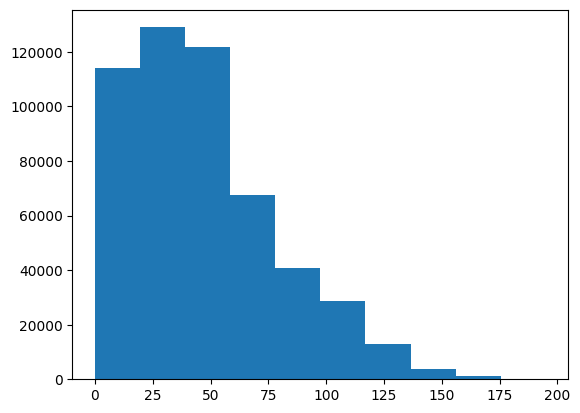

In [20]:
ds1.plot()

(array([114266., 129127., 121928.,  67460.,  38767.,  30654.,  12652.,
          3867.,   1173.,    298.]),
 array([  0. ,  19.4,  38.8,  58.2,  77.6,  97. , 116.4, 135.8, 155.2,
        174.6, 194. ]),
 <BarContainer object of 10 artists>)

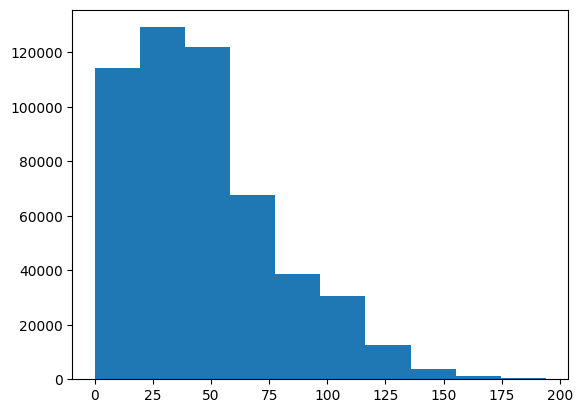

In [21]:
ds2.plot()